<a href="https://colab.research.google.com/github/EgorDudyrev/expailleur/blob/main/Bob%20Ross%20Paintings%20(TD%20DM%20IDMC%20version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some usefull functions

In [1]:
!pip install caspailleur --quiet  # The main subject of study in the current TD
!pip install fcapy --quiet  # Is required to visualize the concept lattices

# Travaux Dirigé: Study Bob Ross paintings with Caspailleur (or vice versa)

![Bob Ross hardcover book photo](https://m.media-amazon.com/images/I/A1BxQEoVjjL._AC_UF1000,1000_QL80_.jpg)
*Bob Ross: The Joy of Painting Hardcover – Illustrated, October 10, 2017 @ Available at [Amazon](https://www.amazon.com/Bob-Ross-Joy-Painting/dp/0789332973)*

**Tutorial description**

The tutorial consists of two parts.

In *Part 1* we discuss some techniques to analyse the data: when they are usefull, when they are not, and when Formal Concept Analysis (FCA) can be of help.

In *Part 2* we concentrate on the cornerstone notions of FCA and how to compute them with `caspailleur`.

## Load the data

Load the dataset, described in "A Statistical Analysis of the Work of Bob Ross" by Walt Hickey at [FiveThirtyEight](https://fivethirtyeight.com/features/a-statistical-analysis-of-the-work-of-bob-ross/)

In [2]:
import pandas as pd

url = 'https://pkgstore.datahub.io/five-thirty-eight/bob-ross/elements-by-episode_csv/data/c01dcab932c6e70122e9f924caece31b/elements-by-episode_csv.csv'
df = pd.read_csv(url)
df = df.drop(columns='title').set_index('episode')
assert (df.values.astype(bool)==df.values).all(),  "The data is not binary"

print(df.shape)
df.head()

(403, 67)


,apple_frame,aurora_borealis,barn,beach,boat,bridge,building,bushes,cabin,cactus,...,tomb_frame,tree,trees,triple_frame,waterfall,waves,windmill,window_frame,winter,wood_framed
episode,,,,,,,,,,,,,,,,,,,,,
s01e01,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
s01e02,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
s01e03,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
s01e04,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
s01e05,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


# Part 1. Common ways to Analyze the data

## Bar plot

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

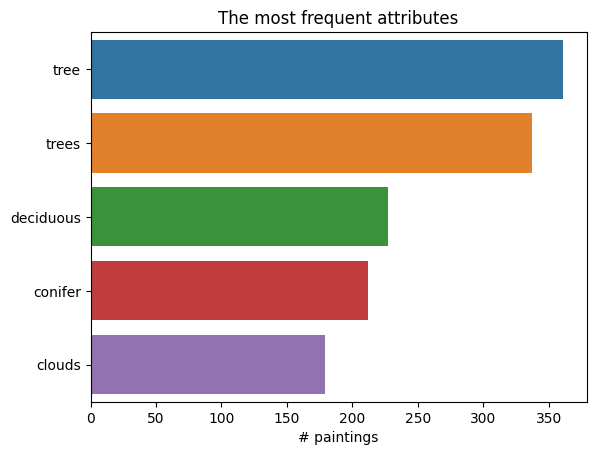

In [4]:
s = df.sum(0).sort_values(ascending=False).head()
sns.barplot(y=s.index, x=s.values)
plt.xlabel('# paintings')
plt.title('The most frequent attributes')
plt.show()

**Pros**
* Easy to draw
* Easy to read.

**Cons**
* Can only show a few "intersting" attributes. A plot with, say, 20 attributes becomes hard to read;
* Does not highlight the dependencies between features:
  * e.g. that the number of paintings with "trees" is included in the number of paintings with "tree".

## Histogram

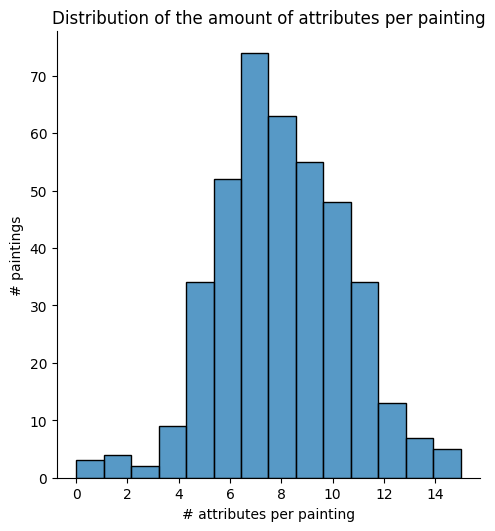

In [5]:
s = df.sum(1)
sns.displot(s)
plt.xlabel('# attributes per painting')
plt.ylabel('# paintings')
plt.title('Distribution of the amount of attributes per painting')
plt.show()

**Pros**
* Easy to draw.
* Easy to read, if the axes are well explained

**Cons**
* Only shows the distribution among one axis.
* The attributes should be carefully constructed.

## PCA

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(df.values)

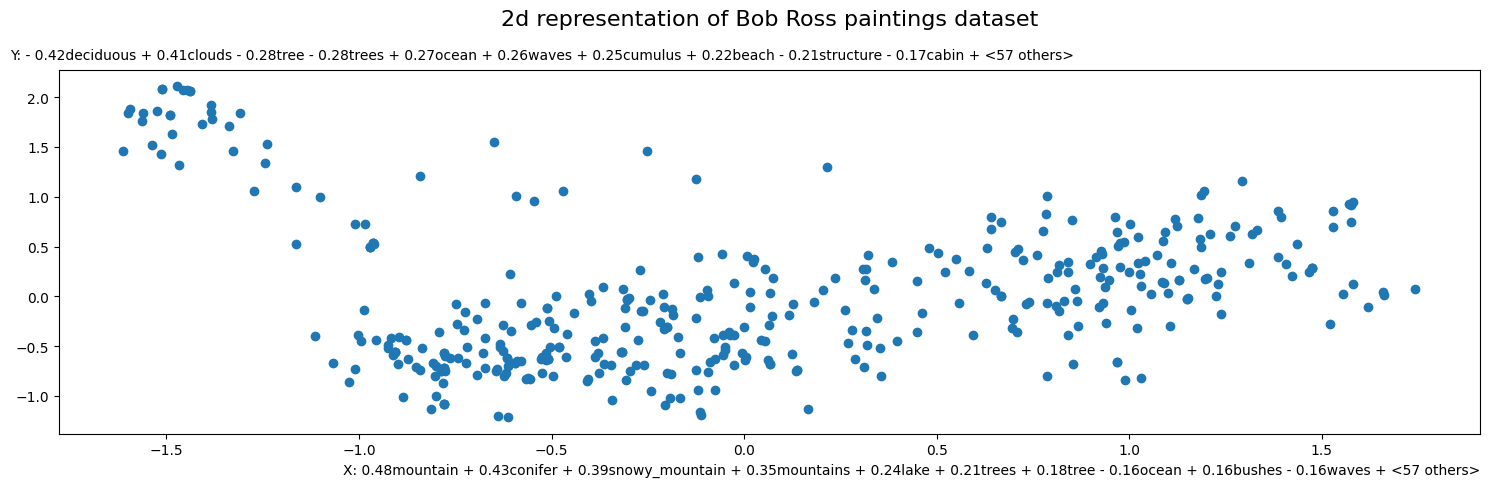

In [8]:
plt.figure(figsize=(15,5))

plt.scatter(X_transformed[:,0], X_transformed[:,1])

s = pd.Series(pca.components_[0], index=df.columns)
s_top = s[s.abs().sort_values(ascending=False).index].head(10)
label = 'X: ' + ''.join([[" - ", " + "][weight > 0] + f"{abs(weight):.2f}{m}" for m, weight in s_top.items()]).strip(' + ') + f" + <{len(s)-len(s_top)} others>"
plt.xlabel(label, loc='right')

s = pd.Series(pca.components_[1], index=df.columns)
s_top = s[s.abs().sort_values(ascending=False).index].head(10)
label = 'Y: ' + ''.join([[" - ", " + "][weight > 0] + f"{abs(weight):.2f}{m}" for m, weight in s_top.items()]).strip(' + ') + f" + <{len(s)-len(s_top)} others>"
plt.ylabel(label, rotation=0, ha='left', y=1.02)

plt.title('2d representation of Bob Ross paintings dataset', y=1.1, size=16)

plt.tight_layout()
plt.show()

**Pros**
* Shows all the data with just one plot.
* One can easily see two clusters (small top-left and big bottom-right).
* The axes are more or less interpretable.

**Cons**
* Every axis summarizes _all_ attributes in the data. So it is hard to identify the attributes underlying each specific point.

## Concept Lattice

In [9]:
def verbose(barray: 'frozenbitarray', names=df.columns):
  "Take bitarray and return a comma-separated names of representing indices of 1s"
  return ','.join(names[list(barray.itersearch(True))])

In [10]:
import numpy as np
import caspailleur as csp

# Step 0. Preprocess the data
itemsets_ba = csp.np2bas(df.values)
crosses_per_columns = list(csp.base_functions.bas2isets(csp.np2bas(df.values.T)))

# Step 1. Compute all extents in intents
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 1)
extent_intent_map = {
    csp.base_functions.extension(intent.itersearch(True), crosses_per_columns): intent
    for intent in intents_ba
}
extents = sorted(extent_intent_map, key=lambda ext: len(ext))
extents_ba = list(csp.base_functions.isets2bas(extents, len(itemsets_ba)))

# Step 2. Find the best concepts (e.g. with the biggest stability)
n_best = 20

stabilities = list(csp.indices.delta_stability_index(extents_ba))
best_indices = list(np.argsort(stabilities)[-n_best:])
best_indices = sorted(best_indices, key=lambda i: extent_intent_map[extents[i]].count())
best_extents = [extents[i] for i in best_indices]
best_intents = [extent_intent_map[extents[i]] for i in best_indices]
best_intents_plus_bottom = best_intents + intents_ba[-1:]

# Step 3. Compute reduced intents that would make nice node titles
children_ordering_with_bottom = csp.sort_intents_inclusion(best_intents_plus_bottom)
children_ordering = [children[:-1] for children in children_ordering_with_bottom[:-1]]
parents_ordering = csp.inverse_order(children_ordering)

reduced_intents = []
for intent, parents in zip(best_intents, parents_ordering):
  reduced_intent = intent
  for parent_i in parents.itersearch(True):
    reduced_intent = reduced_intent & ~best_intents[parent_i]
  reduced_intents.append(reduced_intent)

reduced_intents_verb = [verbose(intent) for intent in reduced_intents]

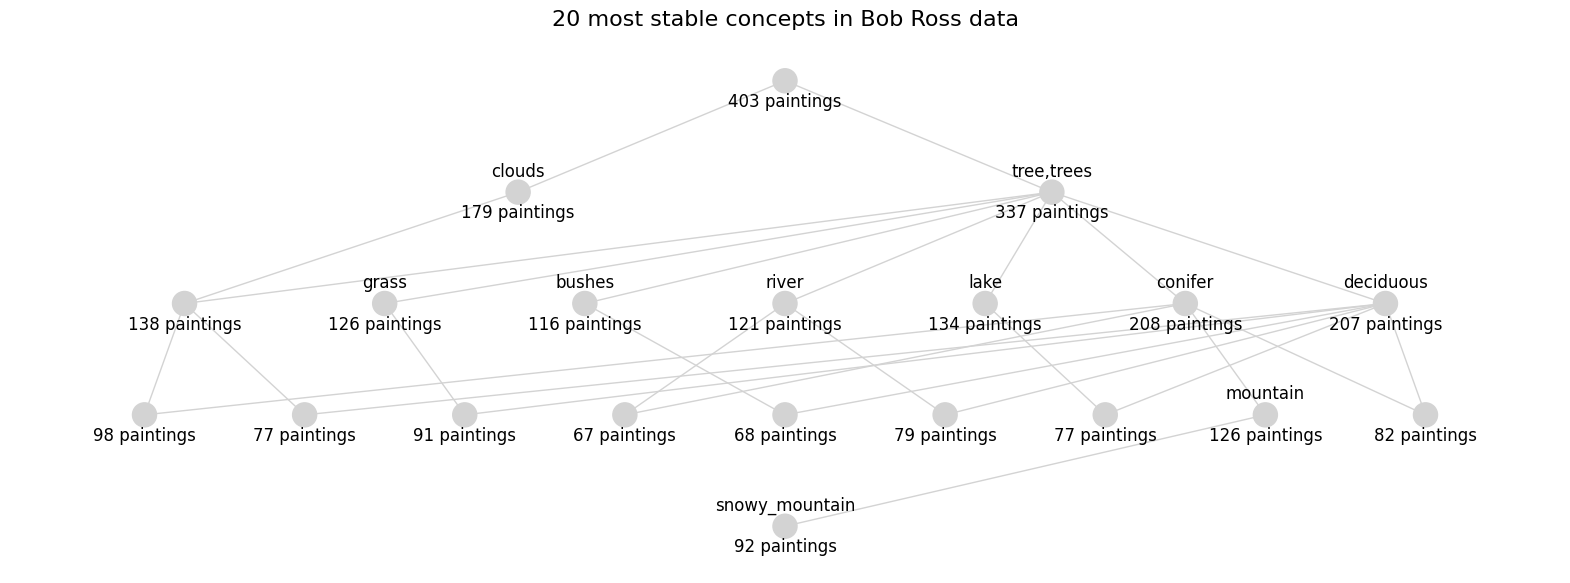

In [11]:
from fcapy.poset import POSet
from fcapy.visualizer import LineVizNx
poset = POSet(best_extents)

fig, ax = plt.subplots(figsize=(20,7))

viz = LineVizNx()
viz.draw_poset(
    poset, ax=ax,
    node_label_func = lambda el_i, P: f"{reduced_intents_verb[el_i]}\n\n{len(best_extents[el_i])} paintings",
)
plt.title(f"{n_best} most stable concepts in Bob Ross data", size=16)

plt.show()

**Pros**
* Shows all the data with just one plot.
* Every node is described with just a few attributes.
* Dependencies between attributes are visible. E.g.:
  * "Tree" and "trees" are put together, as they often appear together
  * Paintings with "river" are subset of paintings with "tree, trees"
  * Paintings with "snowy_mountain" are subset of paintings with "mountain", that are subset of paintings with "conifer", that are subset of paintings with "tree, trees"
  * There is a stable group of 77 paintings that has a lake and decidious trees.

**Cons**
* _Lots_ of boilerplate code.
* It takes time to find the optimal positions of nodes for the best-looking visualization.
* Becomes hard to read, when the number of nodes is big.

_But learning all intrinsic FCA details is a goal of the course, so lots of intrinsic boilerplate code is, in a sence, a good thing_

## Implications

In [12]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp=0.05)
keys_dict = csp.list_keys(intents_ba)

# If no objects are described by all attributes,
# then drop the keys of bottom intent from computations
if not any(itemset_ba.all() for itemset_ba in itemsets_ba):
  keys_dict = {key: i for key, i in keys_dict.items() if not intents_ba[i].all()}

pseudo_intents = csp.list_pseudo_intents_via_keys(keys_dict.items(), intents_ba, use_tqdm=True, n_keys=len(keys_dict))
print(len(pseudo_intents))

Iterate p.intent candidates: 100%|██████████| 540/540 [00:00<00:00, 15748.33it/s]

47


In [13]:
for i, (pintent, intent_i) in enumerate(pseudo_intents):
  pintent_verb = verbose(pintent)
  conclusion = intents_ba[intent_i] & ~pintent
  conclusion_verb = verbose(conclusion)
  print(f"{i}: {pintent_verb} => {conclusion_verb}")

0: winter => tree
1: waves => ocean
2: waterfall => tree
3: trees => tree
4: snowy_mountain => mountain
5: snow => tree
6: river => tree
7: oval_frame => framed
8: fog => tree
9: deciduous => tree
10: conifer => tree
11: cabin => tree
12: bushes => tree
13: beach => ocean
14: path,structure => tree
15: mountain,structure => cabin,tree,trees
16: lake,structure => tree
17: lake,mountains => tree
18: grass,structure => tree
19: grass,mountains => mountain,tree
20: cumulus,mountains => clouds,mountain,tree
21: clouds,mountains => mountain
22: mountain,mountains,snowy_mountain => tree
23: mountains,river,tree => mountain
24: deciduous,tree,winter => snow
25: deciduous,mountains,tree => mountain
26: cumulus,river,tree => clouds,trees
27: conifer,framed,tree => trees
28: conifer,deciduous,tree => trees
29: cabin,mountain,tree => trees
30: bushes,conifer,tree => trees
31: conifer,mountain,tree,winter => trees
32: conifer,mountain,snow,tree => trees
33: clouds,grass,river,tree => trees
34: clou

**Pros**
* Represents all the data with one "visualization"
* Preudo-intent basis shows the minimal amount of implications between subsets of attributes
* Shown implications (or the absence of expected implications) give better understanding of the dataset. E.g.:
  * "0: winter => tree" says that every "winter" painting has a "tree" (and not "trees"). So there are winter paintings with just one tree. For example s0701: https://www.youtube.com/watch?v=kdlHV6ceI_g&list=PLAEQD0ULngi5oKehJMOnVTetKSjfmFrT1
  * "3: trees => tree" says that every painting with many "trees" has at least one "tree". Which is obvious. But there is no implication "mountains => mountain". Which is weird. Is it a bug in the data? You decide (by watching the episode s29e02 https://www.youtube.com/watch?v=2XnIdinwot0&list=PLAEQD0ULngi6c0D5_ELtW5p_NLShDktAN&index=2  )

**Cons**
* Not really a visualization
* Needs some time to compute
* Works nicely on highly discretised data: like binary or categorical data. Real-valued data might have too many implications due to many possible values.
* Need some boilerplate code to be computed


_If computation of pseudo-intents take too much time, try to increase the minimal support of intents (`min_supp` parameter). Or compute proper premises instead: their basis is not minimal, but much faster to compute_

In [14]:
print('Winter paintings with only one tree')
df[(df['winter']&df['tree']&(1-df['trees']))==1][['winter', 'tree', 'trees']]

Winter paintings with only one tree


,winter,tree,trees
episode,,,
s07e01,1,1,0
s08e12,1,1,0
s22e05,1,1,0
s23e13,1,1,0
s25e13,1,1,0


In [15]:
print('Paintings with many mountains, but with no "mountain" (probably a bug in the data)')
df[(df['mountains']&(1-df['mountain']))==1][['mountain', 'mountains']]

Paintings with many mountains, but with no "mountain" (probably a bug in the data)


,mountain,mountains
episode,,
s29e02,0,1


# Part 2. Computing important terms in FCA

All following notions assume we are given a **formal context** $(G, M, I)$ of **objects** $G$, **attributes** $M$, and their **relation** $I \subseteq G \times M$.

Also, we define two "prime" operator (that work as Galois connections):
$$A' = \{m \in M \mid \forall g \in A, (g, m) \in I\}, \quad A \subseteq G,$$
$$B' = \{g \in G \mid \forall m \in M, (g, m) \in I\}, \quad B \subseteq M.$$

Given objects $A \subseteq G$, $A'$ would be the maximal common description of objects $A$. Given description $B \subseteq M$, $B'$ would be the maximal set of objects, described by all attributes $B$.

A pair $(A, B)$ objects $A$ and attributes $B$ such that $A'=B, B'=A$ is called a **formal concept**.  

_I use the term "description" here as a synonym to "a subset of attributes" because it is shorter, and generally approved by FCA community_

_FCA comes from Germany, so the notation comes from German language: $G$ stands for "​die Gegenstände" ("objects"), and $M$ stands for "​​die Merkmale" ("attributes")._

## Intents

Given a subset of objects, an **intent** contains _all_ common attributes of these objects.

More formally, given a subset of objects $A \subseteq G$, **intent** $B = A'$ is the maximal description of objects $A$.

More formally, **intent** $B \subseteq M$ is a closed description, i.e. $B = B''$.


Here, double prime operator $''$ is caled a closure operator ([wiki](https://en.wikipedia.org/wiki/Closure_operator)) because it returns the maximal equvalent subset of objects/attributes.

For example, if $D \subseteq M$ is some subset of attributes, then $B = D''$ is the maximal equivalent subset of attributes. Then, $B''$ would again be equal to $B$, and $(B'')''$ would be equal to $B''$ that is equal to $B$.

The similar mathematical idea of closure is used when discussing transitive closure on graphs.

_Here and after, two subsets of attributes $D, E \subseteq M$ are called equivalent if they describe the same objects $D' = E'$. Or, equivalently, they have the same closure $D''=E''$._

**Finding intents**

Many algorithms were developed. `caspailleur` uses LCM algorithm since it is fast and well-implemented in `scikit-mine` (git: https://github.com/scikit-mine/scikit-mine).

There is also Bordat algorithm, that was covered during the lectures.

In [16]:
%%time
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 1)
print(len(intents_ba))

3463
CPU times: user 1.05 s, sys: 11.1 ms, total: 1.06 s
Wall time: 1.83 s


In [17]:
for intent in intents_ba[:10]:
  print(verbose(intent))


barn
cirrus
cliff
clouds
cumulus
fence
flowers
framed
grass


## Order of intents (i.e. lattice)

We say that one formal concept is less than another when it cover the smaller set of objects or (equivalently) is has bigger description.

More formally, given two concepts $(A, B), (C,D)$ the order of concepts follows the inclusion order on extents $A, C$. Or, equivalently, the order of concepts $(A, B), (C,D)$ follows the subsumption order on intents $B, D$.

More formally, for two formal concepts $(A, B), (C, D)$:
$$ (A, B) \leq (C, D) \iff A \subseteq C \ (\text{or}\ B \supseteq D )$$

In [18]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba)
parents_ordering = csp.sort_intents_inclusion(intents_ba) # For the function to work properly, make sure that the last intent is the bottom (the maximal) one

Here we use the notion of "children" and "parents" ordering.

Given a concept lattice $L$, we say that the children of a concept $(A, B)$ are the closest concepts from $L$ smaller than $(A, B)$.

More formally, given a concept lattice $L$ and a concept $(A, B)$:
$$\text{children}\big((A, B)\big) = \{(C, D) \in L \mid (C, D) < (A, B) \text{ and } \nexists (E, F) \in L \text{ s.t. } (C, D) < (E, F) < (A, B)\} $$.

Analogously, parents of concept $(A, B)$ are the closes concepts from lattice $L$ bigger than $(A, B)$:
$$\text{parents}\big((A, B)\big) = \{(C, D) \in L \mid (A, B) < (C, D) \text{ and } \nexists (E, F) \in L \text{ s.t. } (A, B) < (E, F) < (C, D) \} $$.


Note that, because of the way we order formal concepts, the parent relation on concepts follows the parent relation on concept extents and children relation on concept intents.

In [19]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba)
# We can also compute the transitive order of parents (or "ancestors") if needed
parents_ordering, parents_ordering_trans = csp.sort_intents_inclusion(intents_ba, use_tqdm=True, return_transitive_order=True)

Sorting intents: 100%|██████████| 3463/3463 [00:00<00:00, 12800.16it/s]


In [20]:
print('Indices of parent concept of the concept with intent #10')
list(parents_ordering[10].itersearch(True))

Indices of parent concept of the concept with intent #10


[38, 62, 72, 79, 80, 81]

In [21]:
print('Intent #10', verbose(intents_ba[10]))
print('Intent #38', verbose(intents_ba[38]))

Intent #10 guest
Intent #38 clouds,guest


Intent #10 "guest" is included in intent #38 "clouds,guest". So concept #10 is bigger (i.e. more general) than concept #38.

Obviously, there are no intents between intents #10 and #38, so concept #38 is a child of concept #10. Equivalently, concept #10 is a parent of a concept #38.

_Every intent $B \subseteq M, B''=B$ corresponds to formal concept $(B', B)$, so we can use this terms more or less interchangeably. It is just the order of concept and the order of intents are "reversed"._

In [22]:
list(parents_ordering[38].itersearch(True))

[169, 177]

In [23]:
print('Intent #10', verbose(intents_ba[10]))
print('Intent #38', verbose(intents_ba[38]))
print('Intent #169', verbose(intents_ba[169]))

Intent #10 guest
Intent #38 clouds,guest
Intent #169 clouds,grass,guest


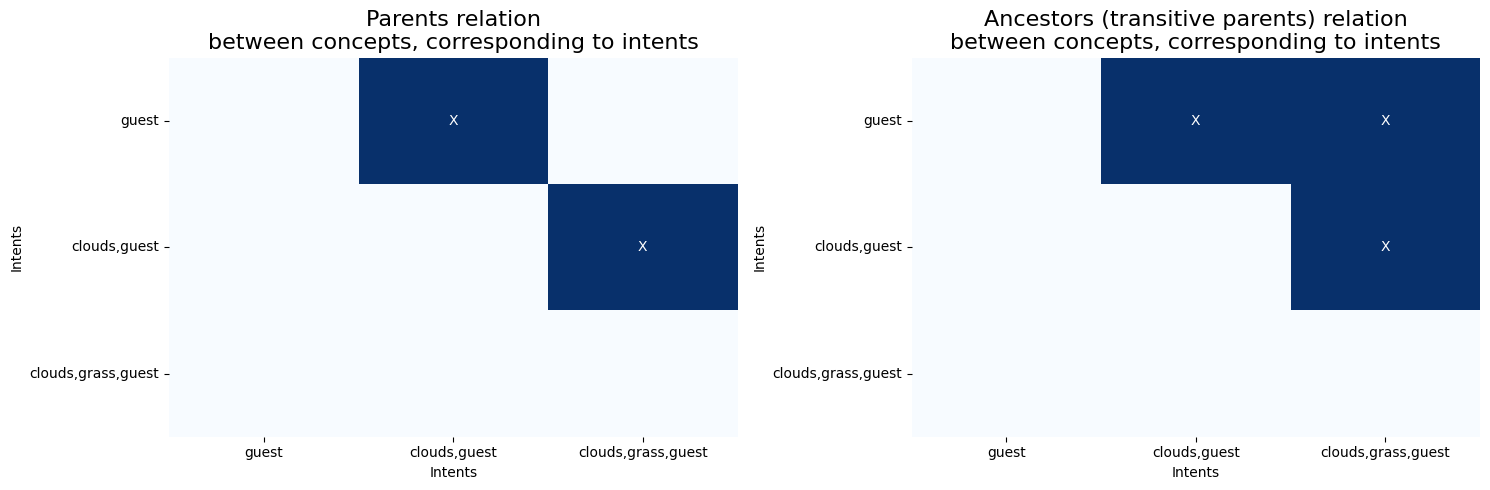

In [24]:
intents_idxs = [10, 38, 169]
parents_relation = [[parents_ordering[i][j] for j in intents_idxs] for i in intents_idxs]
ancestors_relation = [[parents_ordering_trans[i][j] for j in intents_idxs] for i in intents_idxs]

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for (ax, rel, title) in zip(axs, [parents_relation, ancestors_relation], ['Parents', 'Ancestors (transitive parents)']):
  sns.heatmap(rel, ax=ax, annot=[['X' if v else '' for v in row] for row in rel], fmt='', cmap='Blues', cbar=False)
  ax.set_title(f'{title} relation\nbetween concepts, corresponding to intents', size=16)
  ax.set_xticklabels([verbose(intents_ba[i]) for i in intents_idxs])
  ax.set_yticklabels([verbose(intents_ba[i]) for i in intents_idxs], rotation=0)
  ax.set_xlabel('Intents')
  ax.set_ylabel('Intents')


plt.tight_layout()
plt.show()

So, concept ({guest}', {guest}) is a transitive parent of a concept ({clouds,grass,guest}', {clouds,grass,guest}'), but not a (non-transitive) parent.

## Interesting intents

Usually, the data contains too many concepts, to go through all of them. So we should define some notion of "interesting" concepts.



_The study of various interestingness measures of Formal concepts had been done in_
> S.O. Kuznetsov, T. Makhalova,
On interestingness measures of formal concepts,
Information Sciences,
Volumes 442–443,
2018,
Pages 202-219,
ISSN 0020-0255,
https://doi.org/10.1016/j.ins.2018.02.032.

Two popular choices for interestingness measures:

### Support of a concept.

**Support of a concept** $(A, B)$ shows the number of objects, described by the concept.

Formally,
$$\text{supp}\big((A, B)\big) = |A|$$

Analogously, **support of a description** $D \subseteq M$ is the number of objects, described by the description:
$$\text{supp}(D) = |D'|, \quad D \subseteq M$$

Sometimes, _support_ of a description is reffered to as a _frequency_ of this description. Hence, the name of the research field of _frequent itemset mining_.

The idea is that more general concepts (i.e. with higher support) should be more interesting than the very precise ones (with low support).

In [25]:
# Preprocess the data from Pandas.DataFrame
itemsets_ba = csp.np2bas(df.values)
crosses_per_columns_ba = csp.np2bas(df.values.T)
crosses_per_columns = list(csp.base_functions.bas2isets(crosses_per_columns_ba))

# Compute all intents
intents_ba = csp.list_intents_via_LCM(itemsets_ba)

# Support of a concept is the cardinality of its extent
supports = [len(csp.base_functions.extension(intent.itersearch(True), crosses_per_columns)) for intent in intents_ba]

# Selecting the intents with high support
min_supp_thold = 100
best_intents = [intent for intent, s in zip(intents_ba, supports) if s >= min_supp_thold]
print(f"# intents: {len(intents_ba)},\t # intents with support >= {min_supp_thold}: {len(best_intents)}")

# intents: 3463,	 # intents with support >= 100: 29


### Stability of a concept

Stability of a concept is a less trivial interestingness measure of concepts that can highlight both general and precise concepts.

The formula of stability will be considered on TDs in November. Example of using the stability for selecting interesting concepts is shown in Part 1 of the tutorial.

In general, the idea is that some concepts in the data are "created by the noise" and the other are "more stable". So concepts with high stability should be less noisy and more meaningfull.

In [26]:
# Preprocess the data from Pandas.DataFrame
itemsets_ba = csp.np2bas(df.values)
crosses_per_columns_ba = csp.np2bas(df.values.T)
crosses_per_columns = list(csp.base_functions.bas2isets(crosses_per_columns_ba))

# Compute all intents
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 1)

# Compute extents of intents, and order them by increasing cardinality
extent_intent_map = {
    csp.base_functions.extension(intent.itersearch(True), crosses_per_columns): intent
    for intent in intents_ba
}

# Compute stabilites of concepts
extents = sorted(extent_intent_map, key=lambda ext: len(ext))
extents_ba = list(csp.base_functions.isets2bas(extents, len(itemsets_ba)))
stabilities = list(csp.indices.delta_stability_index(extents_ba))

# Select the most stable intents
min_stability_thold = 20
best_extents = [extent for extent, s in zip(extents, stabilities) if s >= min_stability_thold]
best_intents = [extent_intent_map[extent] for extent in best_extents]

print(f"# intents: {len(intents_ba)},\t # intents with stability >= {min_stability_thold}: {len(best_intents)}")

# intents: 3463,	 # intents with stability >= 20: 34


### The need for human curator

Mathematical interestingness measures can filter out many "not-interesting" concepts. However, the concepts that are marked as "interesting" can still be useless for analysis.

For example, imagine that we deal with textual data and we found the concept (<texts containing article "the">, "the").
* Is it frequent (i.e. are there many texts with article "the")? Definitely.
* Is it stable? Most likely, yes.
* Is it interesting? Most likely, no.

So, a data analyst should manually check the concepts with high interestingness measures. If needed, an analyst should update the pipeline and the interestingness measures, so that the obviously bad concepts would be classified as mathematically bad.

You can also invent your own interestingness measures (if you can justify their usage).

Some measures can be specific to some tasks: e.g. precision, recall, and F1-score can be considered as interesting measures of concepts, when applied to binary classification.

## Minimal descriptions

### Keys

Key is a minimal subset of attributes, selecting some specific subset of objects. That is, if we drop any attribute from the key, it will start describing some other subset of objects.

Formally, given a closed description $B \subseteq M, B''=B$, a subset of attributes $D \subseteq M$ is called a key of the closed description $B$ if for any attribute $m \in D$ the closure of $(D \setminus \{m\})''$ does not equal to $B$:
$$D \text{ is a key of } B \iff D''=B, \forall m \in D, (D \setminus \{m\})'' \neq B $$

Sometimes, the keys are also called the minimal generators.

**Finding keys**

Apparently, finding _all_ keys in the context takes about the same time as finding all key for a _single_ intent.

There is a nice property for keys:
> Every subset of a key is a key (of another intent)

Or, mathematically:
$$\forall E \subseteq M, (E \text{ is a key}) \implies (\forall D \subseteq E, D \text{ is a key}).$$

Therefore, if $D \subseteq M$ is _not_ a key, then every description $E$ greater than $D$ (i.e. $D \subset E$) is also _not_ a key.

**An algorithm to find all the keys**

Let $\mathbb{D}_n$ denote keys of size $n$. That is, $\forall D \in \mathbb{D}_n, D \text{ is a key and } |D| = n$. The task is to find all keys $\mathbb{D} = \bigcup_{n=0}^\infty D_n$.

Note that there is always one key of size 0: $\mathbb{D}_0 = \{\emptyset\}$

For $n$ in $[1, \infty]$:
0. if found no $\mathbb{D}_{n-1}$ (i.e. $|\mathbb{D}_{n-1}| = 0$) then _stop_;
1. Initialize $\mathbb{D}_{n} = \emptyset$;
2. For every key $D \in \mathbb{D}_{n-1}$, for every attribute $m \in M \setminus D$:
  * Create candidate key $E = D \cup \{ b \} $;
  * If any subset of $E$ is not a key, then $E$ is not a key;
  
    (i.e. if $\exists \tilde{m} \in E$ s.t. $E \setminus \{\tilde{m}\} \not \in \mathbb{D}_{n-1}$ then $E$ is not a key)
  * If the closure of $E$ equals to the closure of one of its subsets, then $E$ is not a key;
  
    (i.e. if $\exists \tilde{m} \in E$ s.t. $(E \setminus \{\tilde{m}\})'' = E''$ then $E$ is not a key)
  * If candidate key $E$ passed two previous checks, then it is a key. Add it to the set $\mathbb{D}_{n}$.

Together, all found sets $\mathbb{D}_n$ form a set of keys of the context.

An analogous algorithm is implemented in `caspailleur`'s `list_key` function (source code: https://github.com/EgorDudyrev/caspailleur/blob/6848fd05479a003337ca41bee8c5db66064147f1/caspailleur/mine_equivalence_classes.py#L240)

In [27]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba)
keys_dict = csp.list_keys(intents_ba)

Let us analyse the obtained keys.

#### First, we want to see how many keys an intent has on average.

In [28]:
keys_per_intent = [set() for _ in range(len(intents_ba))]
for key, intent_i in keys_dict.items():
  keys_per_intent[intent_i].add(key)

n_keys_per_intent = pd.Series([len(keys) for keys in keys_per_intent])

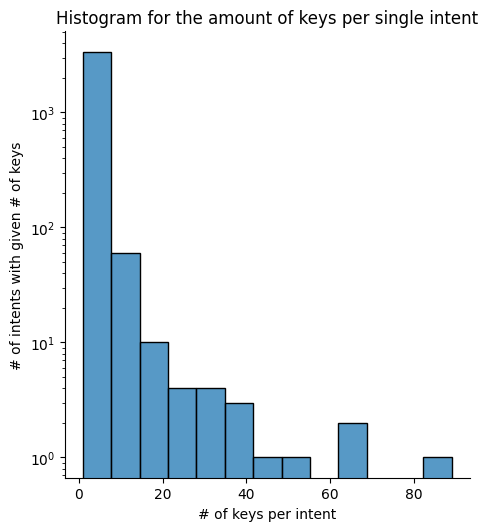

In [29]:
sns.displot(n_keys_per_intent[:-1])
plt.yscale('log')
plt.xlabel('# of keys per intent')
plt.ylabel('# of intents with given # of keys')
plt.title('Histogram for the amount of keys per single intent')
plt.show()

In [30]:
print('Indices of intents with 10 keys:', list(n_keys_per_intent[n_keys_per_intent==10].index))

Indices of intents with 10 keys: [3261, 3334, 3336, 3337, 3370, 3393, 3422, 3425]


In [31]:
i = (n_keys_per_intent==10).argmax()
print('Intent:', verbose(intents_ba[i]))
print('Keys:', [verbose(key) for key in keys_per_intent[i]])

Intent: clouds,cumulus,moon,night,ocean,palm_trees,tree,trees,waves
Keys: ['palm_trees,trees', 'moon,ocean', 'clouds,moon', 'cumulus,night,tree', 'cumulus,night,trees', 'palm_trees,tree', 'moon,waves', 'moon,palm_trees', 'night,palm_trees', 'cumulus,moon']


So every painting with 'moon' and 'waves' also has 'clouds', 'cumulus', 'night', 'ocean', 'palm_trees', 'tree', and 'trees'.

Implication "moon & waves => palm_trees" seems strange. Let us double check it

In [32]:
df[(df['moon']&df['waves'])==1][['palm_trees']]

,palm_trees
episode,
s03e02,1


So there was just one episode with 'moon' and 'waves', and this episode also included palm trees.

If your want to find such specific implications (that cover just one object from the data), think about specifiyng minimal support parameter (i.e. `min_supp`) when computing intents.

### Passkeys

When there are many keys corresponding to the same intent, we might want to look at the smallest of the keys. We call such smallest key a **passkey** (the word is a synonym to a "lockpick").

More formally, **passkey** is a key of minimal size.

In [33]:
# First the index of the intent with the maximal difference in key sizes
i = pd.Series([max(key.count() for key in keys) - min(key.count() for key in keys) for keys in keys_per_intent[:-1]]).idxmax()

print('Intent:', verbose(intents_ba[i]))
print('Keys:', [verbose(key) for key in keys_per_intent[i]])

Intent: deciduous,framed,grass,lake,mountain,snowy_mountain,tree,wood_framed
Keys: ['wood_framed', 'deciduous,framed,grass,lake,snowy_mountain']


So both 'wood_framed' and 'deciduous,framed,grass,lake,snowy_mountain' are minimal descriptions: one cannot remove a single attribute from these descriptions and still describe the same set of paintings.

However, 'wood_framed' is a much shorter description that 'deciduous,framed,grass,lake,snowy_mountain'. So, in this case, both descriptions are keys, but 'wood_framed' is also a _passkey_.

# Implications

## Proper premises

Proper premise $P$ is a subset of attributes $M$ that is 1) not closed, and 2) whose closure contains attributes, found neither in the closures of subsets of $P$ nor in $P$ itself.

Mathematically,
$$\forall P \subseteq M, P \text{ is a proper premise} \iff P'' \neq P \text{ and }\bigcup_{D \subset P} D'' \neq P''.$$

The set of proper premises, together with their closures form a **proper premise bass** or **direct canonical basis**. So all the implication in the data can be derived from the proper premises (and their closures) by appliying Armstrong rules.

**Finding proper premises**

One can show that every proper premise is a key:
$$\forall P \subseteq M, P \text{ is a proper premise} \implies P \text{ is a key}.$$

So, the simplest way to find the proper premises is:
1. Find all the keys (for example, via the algorithm above)
2. For every key $D$ in the set of keys $\mathbb{D}$:
  * Check that $D$ is not closed, i.e. $D\neq D''$,
  * Check that $D''$ contains attributes, found neither in the lesser intent, nor in $D$:
$$ D \cup \bigcup_{m \in D} (D \setminus \{m\})'' \neq D''$$
  * If key $D$ passed two previous checks, then it is also a proper premise.

The analogous algorithm is used in `caspailleur` package (source code: https://github.com/EgorDudyrev/caspailleur/blob/6848fd05479a003337ca41bee8c5db66064147f1/caspailleur/implication_bases.py#L93)

In [34]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp=0.05)  # Do not find intents that cover less than 5% of the objects, as they will produce too specific implications
keys_dict = csp.list_keys(intents_ba)
keys_dict = {key: intent_i for key, intent_i in keys_dict.items() if not intents_ba[intent_i].all()}  # Filter out keys corresponding to the bottom concept

proper_premises = list(csp.iter_proper_premises_via_keys(intents_ba, keys_dict))
print('# proper premises', len(proper_premises))

# proper premises 49


In [35]:
for premise, intent_i in proper_premises:
  conclusion = intents_ba[intent_i] & ~premise
  print(verbose(premise), '=>', verbose(conclusion))

beach => ocean
bushes => tree
cabin => tree
conifer => tree
deciduous => tree
fog => tree
oval_frame => framed
river => tree
snow => tree
snowy_mountain => mountain
trees => tree
waterfall => tree
waves => ocean
winter => tree
bushes,conifer => tree,trees
cabin,mountain => tree,trees
clouds,mountains => mountain
conifer,deciduous => tree,trees
conifer,framed => tree,trees
cumulus,mountains => clouds,mountain,tree
cumulus,river => clouds,tree,trees
deciduous,mountains => mountain,tree
deciduous,winter => snow,tree
grass,mountains => mountain,tree
grass,structure => tree
lake,mountains => tree
lake,structure => tree
mountain,structure => cabin,tree,trees
mountains,river => mountain,tree
mountains,snowy_mountain => mountain,tree
path,structure => tree
bushes,clouds,lake => tree,trees
bushes,clouds,mountains => mountain,tree,trees
bushes,grass,mountain => tree,trees
cabin,conifer,lake => tree,trees
clouds,conifer,river => tree,trees
clouds,conifer,snowy_mountain => mountain,tree,trees
clou

## Pseudo-intents


Pseudo-intent $P$ is a subset of attributes $M$ that is 1) not closed, and 2) contains the closures of all lesser pseudo-intents.

Mathematically,
$$\forall P \subseteq M, P \text{ is a pseudo-intent} \iff P'' \neq P \text{ and } Q'' \subset P \text{ for every pseudo-intent } Q \subset P.$$

The set of pseudo-intents, together with their closures form a **pseudo-intent basis** or **Duquenne-Guigues basis** or **canonical basis** or **stembase**. So all the implication in the data can be derived from the proper premises (and their closures) by appliying Armstrong rules.

An important property of this basis is that it is _cardinality-minimal_. That is it contains the smallest amount of implications. The drawback is that this basis is sometimes hard to compute.

**Finding pseudo-intents**

One can show that every pseudo-intent is a saturated key. That is, given a set of (lesser) pseudo-intents $\mathbb{P}$, and a set of keys $\mathbb{D}$:
$$\forall P \subseteq M, P \text{ is a pseudo-intent } \implies \exists D \in \mathbb{D}, \text{saturate}(D, \mathbb{P}) = P.$$

The function $\text{saturate}(D, \mathbb{P})$ updates description $D$ so that it would satisfy implications from $\mathbb{P}$.

Algorithm of **saturating** $D$ with $\mathbb{P}$:
0. Initialise $D_\text{sat} = D$,
1. Find a premise $P \in \mathbb{P}$ such that $P \subset D_\text{sat}, P'' \not \subset D_\text{sat}$,
2. Replace $D_\text{sat}$ with $D_\text{sat} \cup P''$
3. Repeat steps 1-2 untill no premises found in step 1 (i.e. repeat while $\exists P \in \mathbb{P}, \text{ s.t. } P \subset D_\text{sat}, P'' \not \subset D_\text{sat})$)
The resulting $D_\text{sat}$ would be a saturated version of description $D$, w.r.t. premises $\mathbb{P}$.

There are many algorithms aimed to find all pseudo-intents in an optimal way.
Here, we provide an algorithm, that might be not optimal but relatively simple.

Algorithm to **compute all pseudo-intents**
0. Initialise the set of pseudo-intents $\mathbb{P} = \emptyset$;
1. Iterate through every key $D$ in the data, ordered by increasing cardinality:
  * Compute the saturated version of the key: $D_\text{sat} = \text{saturate}(D, \mathbb{P})$,
  * Check if the saturated key is not closed $D_\text{sat}'' \neq D_\text{sat}$,
  * If $D_\text{sat}$ has passed the previous check then it is a pseudo-intent. So add it to the set $\mathbb{P}$, otherwise go to the next key $D$ in Step 1.
  * Go through every pseudo-intent $P \in \mathbb{P}$, and replace it with its new saturated version $P_\text{sat} = \text{saturate}(P, \mathbb{P})$;
  * Remove the pseudo-intents $P \in \mathbb{P}$ that now became closed (i.e. P''=P).
In the end, the set $\mathbb{P}$ would contain all pseudo-intents from the context.

The analogous algorithm is used in `caspailleur` package (source code: https://github.com/EgorDudyrev/caspailleur/blob/6848fd05479a003337ca41bee8c5db66064147f1/caspailleur/implication_bases.py#L116)

In [36]:
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp=0.05)  # Do not find intents that cover less than 5% of the objects, as they will produce too specific implications
keys_dict = csp.list_keys(intents_ba)
keys_dict = {key: intent_i for key, intent_i in keys_dict.items() if not intents_ba[intent_i].all()}  # Filter out keys corresponding to the bottom concept

pseudo_intents = csp.list_pseudo_intents_via_keys(keys_dict.items(), intents_ba, use_tqdm=True, n_keys=len(keys_dict))
print()
print('# pseudo-intents', len(pseudo_intents))

Iterate p.intent candidates: 100%|██████████| 540/540 [00:00<00:00, 9101.78it/s]


# pseudo-intents 47


So we have 47 pseudo-intents versus 49 proper premises

In [37]:
for pintent, intent_i in pseudo_intents:
  conclusion = intents_ba[intent_i] & ~pintent
  print(verbose(pintent), '=>', verbose(conclusion))

winter => tree
waves => ocean
waterfall => tree
trees => tree
snowy_mountain => mountain
snow => tree
river => tree
oval_frame => framed
fog => tree
deciduous => tree
conifer => tree
cabin => tree
bushes => tree
beach => ocean
path,structure => tree
mountain,structure => cabin,tree,trees
lake,structure => tree
lake,mountains => tree
grass,structure => tree
grass,mountains => mountain,tree
cumulus,mountains => clouds,mountain,tree
clouds,mountains => mountain
mountain,mountains,snowy_mountain => tree
mountains,river,tree => mountain
deciduous,tree,winter => snow
deciduous,mountains,tree => mountain
cumulus,river,tree => clouds,trees
conifer,framed,tree => trees
conifer,deciduous,tree => trees
cabin,mountain,tree => trees
bushes,conifer,tree => trees
conifer,mountain,tree,winter => trees
conifer,mountain,snow,tree => trees
clouds,grass,river,tree => trees
clouds,deciduous,grass,tree => trees
clouds,conifer,structure,tree => cabin
clouds,conifer,river,tree => trees
cabin,conifer,lake,tree